In [15]:
import time

from model import LitModel
from main import (
    build_experiment,
    DEFAULT_PARAMS,
    get_cifar_models,
    available_corruptions,
)

import torch
import lightning as L

all_corruptions = available_corruptions()
print(all_corruptions)

models = get_cifar_models(lib="torch")

print(list(models.keys()))

['gaussian_pixels', 'random_labels', 'random_pixels', 'partial_labels', 'shuffled_pixels']
['resnet18', 'resnet34', 'alexnet', 'inception', 'mlp_1x512', 'mlp_3x512']


In [16]:
import lightning.pytorch as pl
from lightning.pytorch.core.module import LightningModule
from lightning.pytorch.callbacks import ModelPruning
from lightning.pytorch.utilities.rank_zero import rank_zero_debug

class LitModelPruning(ModelPruning):
    def filter_parameters_to_prune(self, parameters_to_prune):
        # filter linear layers
        filter_names = ["Linear"]
        return [
            (param, name)
            for param, name in parameters_to_prune
            if not any([filter_name in param.__class__.__name__ for filter_name in filter_names])
        ]
    
    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: LightningModule) -> None:
        if self._prune_on_train_epoch_end:
            rank_zero_debug("`ModelPruning.on_train_epoch_end`. Applying pruning")
            self._run_pruning(pl_module.current_epoch)

def apply_prunning_every(k):
    """
    Apply pruning every k epochs, ignores epoch 0.
    
    Parameters:
        k (int): apply pruning every k epochs

    Returns:
        Callable: wrapper with the following signature: `wrapper(current_epoch) -> bool`
    """

    return lambda current_epoch: current_epoch % k == 0 and current_epoch != 0

In [18]:
import os
import wandb
import torch

torch.set_float32_matmul_precision('medium')
hparams = DEFAULT_PARAMS.copy()

MODEL_NAME = "alexnet"
CORRUPTION_NAME = "normal_labels"
CORRUPTION_PROB = 0.0

model = models[MODEL_NAME]

hparams["model_name"] = MODEL_NAME
hparams["n_classes"] = 10
hparams["drop_return_index"] = True
hparams["corrupt_name"] = CORRUPTION_NAME
hparams["corrupt_prob"] = CORRUPTION_PROB
hparams["val_every"] = 1


experiment_name = f"{hparams['model_name']}_{hparams['corrupt_name']}_{hparams['corrupt_prob']}"

os.environ.update({"WANDB_NOTEBOOK_NAME": "pruning.ipynb"})

try:
    wandb.finish()
except Exception:
    pass

pruning_cb = LitModelPruning(
    pruning_fn="l1_unstructured",
    amount=0.1,
    use_global_unstructured=True,
    use_lottery_ticket_hypothesis=True,
    apply_pruning=apply_prunning_every(5),
    verbose=2
)

trainer = L.Trainer(
    max_epochs=30,
    logger=[wb_logger, tb_logger],
    default_root_dir="logs",
    check_val_every_n_epoch=hparams["val_every"],
    callbacks=[L.pytorch.callbacks.EarlyStopping(monitor="valid/loss", patience=3)],
    accelerator="gpu",
)

data = build_experiment(
    corrupt_name=hparams['corrupt_name'],
    corrupt_prob=hparams['corrupt_prob'],
    batch_size=hparams["batch_size"],
)
train_loader = data["normal_labels"]["train_loader"]
val_loader = data["normal_labels"]["val_loader"]

# dict(model.named_parameters()).keys()

hparams["learning_rate"] = 0.01

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


In [11]:
tb_logger = L.pytorch.loggers.TensorBoardLogger(hparams["log_dir"], name="pruning")
wb_logger = L.pytorch.loggers.WandbLogger(project="pruning", name=experiment_name)
# wb_logger.watch(model)
wandb.run.log_code(".")
pl_model = LitModel(model, hparams=hparams)

start_time = time.time()
trainer.fit(
    pl_model,
    train_loader,
    val_loader,
)
print(f"Training took {time.time() - start_time:.2f} seconds")
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params
------------------------------------------------------
0 | net            | SmallAlexNet       | 56.8 M
1 | train_acc      | MulticlassAccuracy | 0     
2 | valid_acc      | MulticlassAccuracy | 0     
3 | valid_top5_acc | MulticlassAccuracy | 0     
4 | test_acc       | MulticlassAccuracy | 0     
5 | test_top5_acc  | MulticlassAccuracy | 0     
------------------------------------------------------
56.8 M    Trainable params
0         Non-trainable params
56.8 M    Total params
227.307   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 3: 100%|██████████| 196/196 [00:09<00:00, 19.64it/s, v_num=q4_6, valid/loss=1.600, valid/acc=0.733, valid/top5_acc=0.973, train/loss=0.0331, train/acc=0.989]
Training took 42.17 seconds


epoch,▁▁▃▃▆▆██
train/acc,▁▅▇█
train/loss,█▄▂▁
trainer/global_step,▃▁▃▄▁▄▆▁▆█▁█
valid/acc,▁▅▇█
valid/loss,▁▃▅█
valid/top5_acc,▁▁▆█
epoch,3
train/acc,0.9895
train/loss,0.03314
trainer/global_step,783


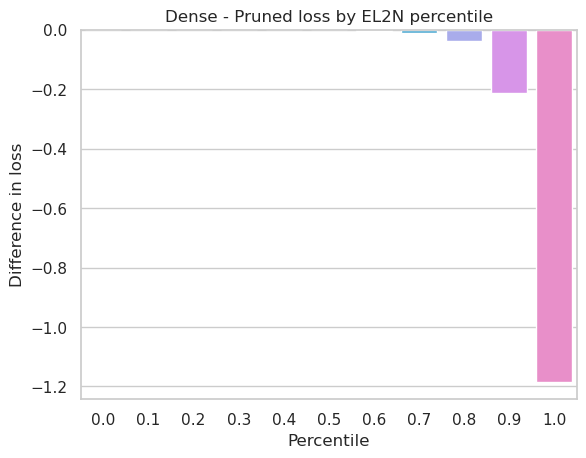

In [7]:
import pandas as pd
import wandb
import json

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

project = "pruning"
pruned_run_id = "wpuog9ol"
dense_run_id = "l0d5pfq4"


def get_latest_scores(run_id):
    api = wandb.Api()
    run = api.run(f"{project}/{run_id}")
    # list all artifacts, filtered by type
    table_names = list(
        [a.name for a in run.logged_artifacts() if "trainscores" in a.name]
    )
    latest_table = table_names[-1]

    with open(api.artifact(f"{project}/{latest_table}").file()) as f:
        json_dict = json.load(f)

    return pd.DataFrame(json_dict["data"], columns=json_dict["columns"])


def compute_el2n_percentile(df):
    # group by epoch and compute the percentile of the column score, use round to have groups of 0.1
    df["el2n_percentile"] = df.groupby("epoch")["score"].rank(pct=True).round(1)
    return df


# plot as columns x=el2n_percentile, y=avg_loss_by_percentile
def plot_avg_by_percentile(avg_by_percentile, name_to_plot="loss"):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax = sns.barplot(x=avg_by_percentile.index, y=avg_by_percentile.values, ax=ax)

    ax.set_title(f"Average {name_to_plot} by percentile")
    ax.set_xlabel("Percentile")
    ax.set_ylabel(f"Average {name_to_plot}")

    return fig, ax


def plot_difference_by_perccentile(
    dense_scores, pruned_scores, column_to_plot="loss", **plot_kwargs
):
    difference_by_percentile = (
        dense_scores.groupby("el2n_percentile")[column_to_plot].mean()
        - pruned_scores.groupby("el2n_percentile")[column_to_plot].mean()
    )

    fig, ax = plt.subplots(**plot_kwargs)
    ax = sns.barplot(
        x=difference_by_percentile.index, y=difference_by_percentile.values, ax=ax
    )
    ax.set_title(f"Dense - Pruned {column_to_plot} by EL2N percentile")
    ax.set_xlabel("Percentile")
    ax.set_ylabel(f"Difference in {column_to_plot}")

    return fig, ax


pruned_scores = get_latest_scores(run_id=pruned_run_id)
pruned_scores = compute_el2n_percentile(pruned_scores)

dense_scores = get_latest_scores(run_id=dense_run_id)
dense_scores = compute_el2n_percentile(dense_scores)


plot_difference_by_perccentile(dense_scores, pruned_scores, column_to_plot="loss");

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


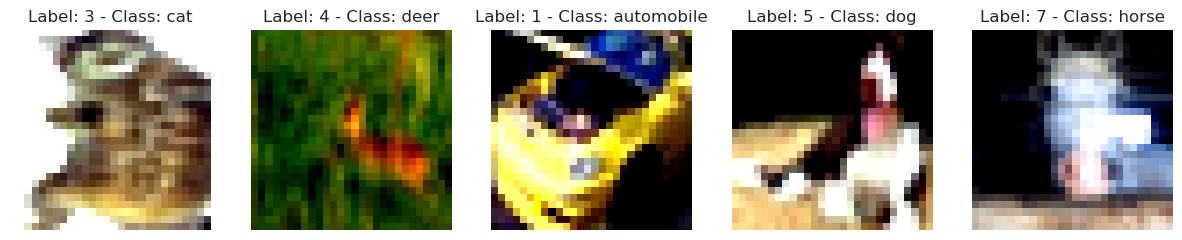

In [37]:
# sample n from highest percentile
n = 5
highest_percentile = 0.9

samples_id = dense_scores[dense_scores["el2n_percentile"] == highest_percentile].sample(n).sample_id.values
samples_imgs = [data["normal_labels"]["train_set"][id][0].permute(1, 2, 0) * 0.5 + 0.5 for id in samples_id]
samples_labels = [data["normal_labels"]["train_set"][id][1] for id in samples_id]
samples_classes = [data["normal_labels"]["train_set"].classes[label] for label in samples_labels]


fig, axs = plt.subplots(1, n, figsize=(15, 10))
for i, (img, label, class_name) in enumerate(zip(samples_imgs, samples_labels, samples_classes)):
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {label} - Class: {class_name}")
    axs[i].axis("off")

In [5]:
# open local tensorbard logs
import glob
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator

def load_tf(dirname):
    dirname = glob.glob(dirname + '/*')[0]
    
    ea = event_accumulator.EventAccumulator(dirname)
    ea.Reload()
    mnames = ea.Tags()['scalars']
    pruned_scores = pd.DataFrame(columns=["step"])
    for n in mnames:
        current_pruned_scores = pd.DataFrame(ea.Scalars(n))
        current_pruned_scores = current_pruned_scores.rename(columns={"value": n})
        current_pruned_scores.drop("wall_time", axis=1, inplace=True)

        pruned_scores = pruned_scores.merge(current_pruned_scores, on="step", how="right")
        pruned_scores.drop_duplicates(inplace=True)

    return pruned_scores

log_dir = "logs/lightning_logs/version_64/"
# load_tf(log_dir)

In [6]:
from matplotlib import pyplot as plt
pruned_scores = pd.read_csv(
    log_dir + "lightning_logs_train-el2n.csv",
    index_col=1,
    usecols=[1, 2, 3],
).reset_index()


# f = plt.figure(figsize=(20, 20))

# for e in range(0, 9):  
#     pruned_scores_e = pruned_scores[pruned_scores["epoch"] == e]
#     sample = pruned_scores_e.sample(100)
#     # scatter plot of x=sample_id, y=score using f.add_subplot
#     # plt.scatter(...)
#     ax = f.add_subplot(3, 3, e + 1)
    
#     ax.hist(x=sample["sample_id"], weights=sample["score"], range=(0, 50000), bins=100, density=True)

# plt.tight_layout()
# plt.show()

# compute percentiles
pruned_scores["percentile"] = pruned_scores.groupby("epoch")["score"].rank(pct=True)
pruned_scores.sort_values("percentile", ascending=False, inplace=True)
pruned_scores

,sample_id,epoch,score,percentile
499675,9235,9.0,1.414212e+00,1.00000
288560,27949,5.0,1.414192e+00,1.00000
43930,31694,0.0,1.286880e+00,1.00000
326129,9235,6.0,1.414071e+00,1.00000
139748,47063,2.0,1.407979e+00,1.00000
...,...,...,...,...
450579,22792,9.0,4.496017e-15,0.00002
296397,29671,5.0,1.488372e-08,0.00002
398170,27187,7.0,3.713127e-12,0.00002
154450,6601,3.0,9.871068e-06,0.00002


In [7]:
!tensorboard --logdir logs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.
